Anomaly detection in realAWSCloudwatch data RDS (relational database service) CPU utilization

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(16, 7)

import mxnet as mx
from mxnet import nd, autograd, gluon

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

### Load datasets:

In [16]:
path1 = './data/realAWSCloudwatch/realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'
path2 = './data/realAWSCloudwatch/realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

df1.head()

,timestamp,value
0,2014-02-14 14:30:00,6.456
1,2014-02-14 14:35:00,5.816
2,2014-02-14 14:40:00,6.268
3,2014-02-14 14:45:00,5.816
4,2014-02-14 14:50:00,5.862


### Make timestamp conversions

In [17]:
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

df1['time_epoch'] = (df1['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
df2['time_epoch'] = (df2['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

### Plot data

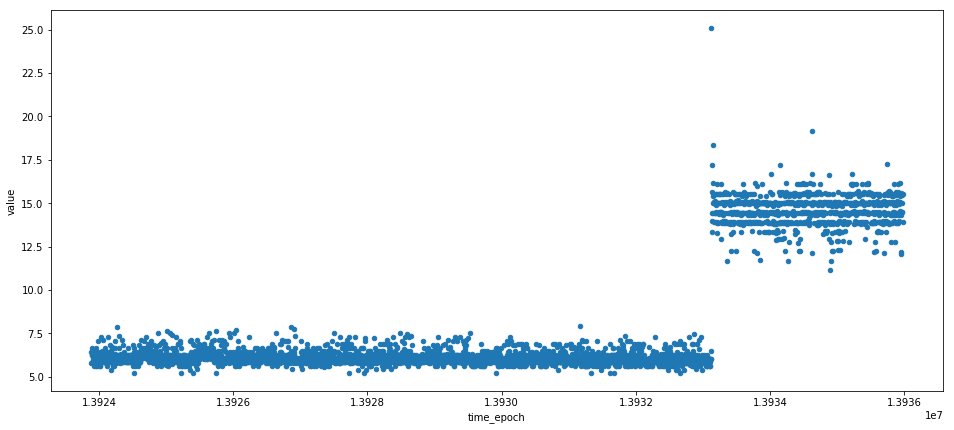

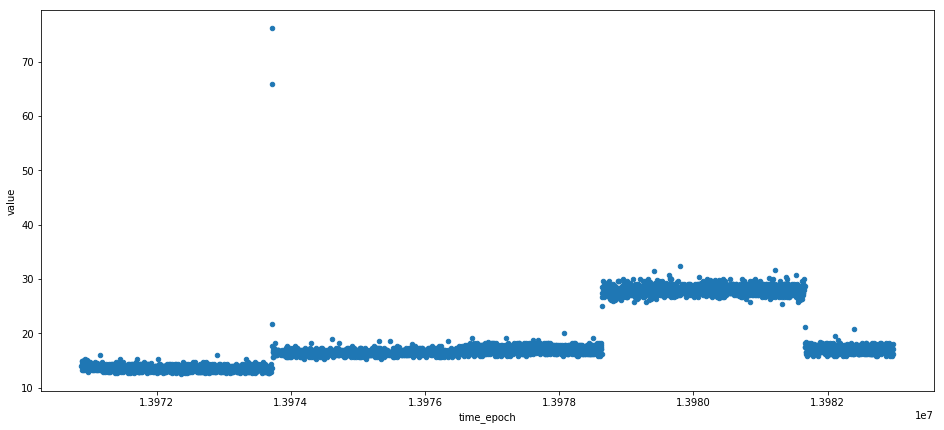

In [18]:
df1.plot(x='time_epoch', y='value', kind='scatter')
df2.plot(x='time_epoch', y='value', kind='scatter')

### Extract additional features

In [19]:
df1['hours'] = df1['timestamp'].dt.hour
df1['week_day'] = df1['timestamp'].dt.dayofweek

df2['hours'] = df2['timestamp'].dt.hour
df2['week_day'] = df2['timestamp'].dt.dayofweek

### Plot hours and day of week histograms

In [20]:
def plot_histogram (df, category_count, category_name):
    values = []

    for index in range(category_count):
        values.append(df.loc[df[category_name] == index, 'value'])
    fig, ax = plt.subplots()
    heights, bins = np.histogram([values[0]])
    histogram_tuples = [[heights, bins]]

    for index in range(1, category_count):
        heights, bins = np.histogram(values[index], bins=histogram_tuples[index - 1][1])
        histogram_tuples.append([heights, bins])

    width = (histogram_tuples[0][1][1] - histogram_tuples[0][1][0]) / 30

    for index in range(category_count):
        ax.bar(histogram_tuples[index][1][:-1]+width*index, histogram_tuples[index][0]*100/values[index].count(), width=width, facecolor='blue', label=category_name)

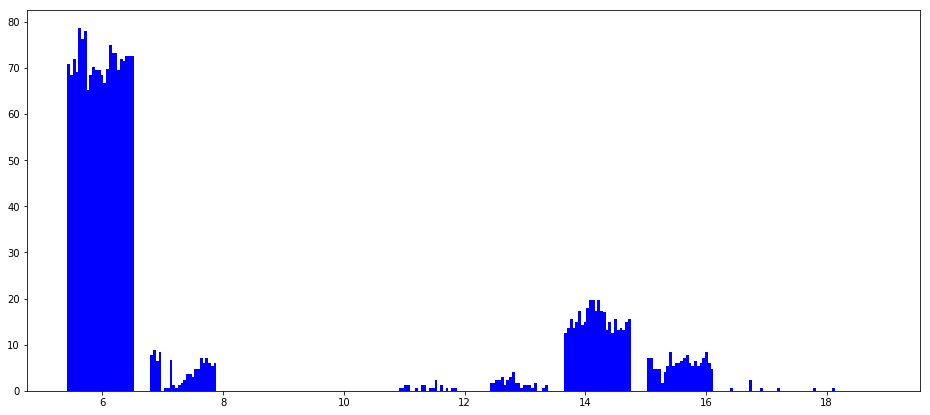

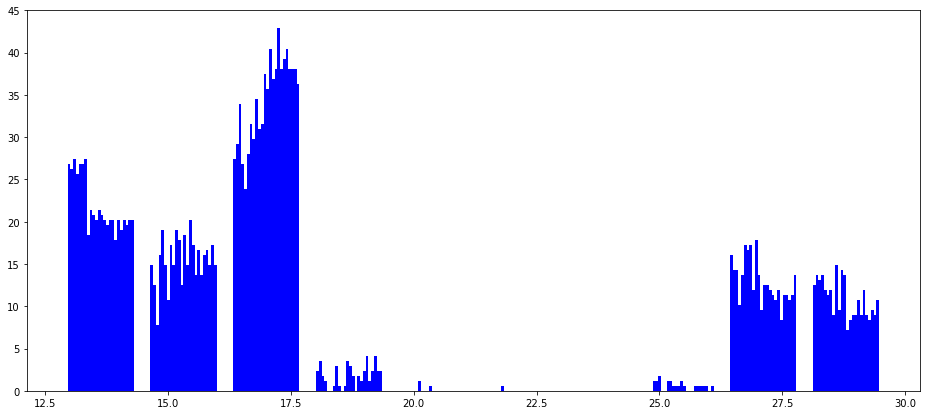

In [21]:
plot_histogram (df1, 24, 'hours')
plot_histogram (df2, 24, 'hours')

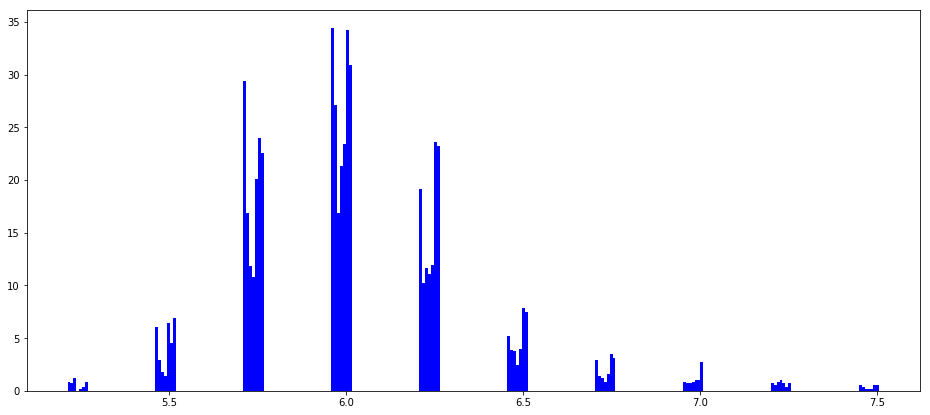

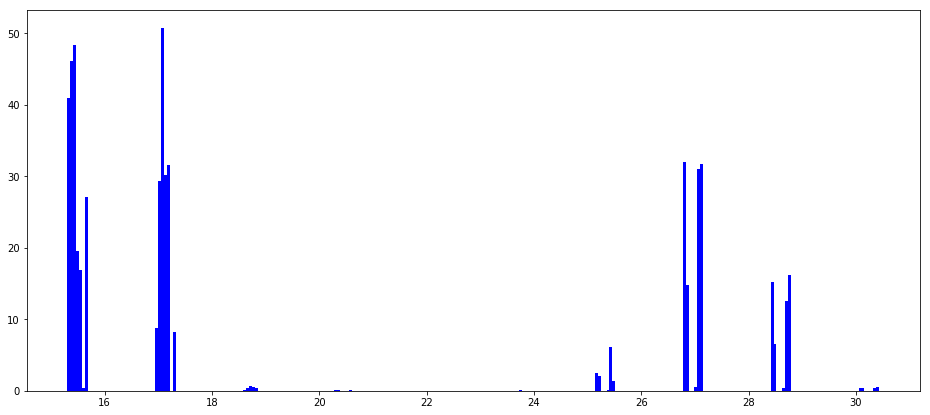

In [22]:
plot_histogram (df1, 7, 'week_day')
plot_histogram (df2, 7, 'week_day')

### K-means

In [23]:
outliers_fraction = 0.01

def prepare_data_for_k_means (df):
    data = df[['value', 'hours', 'week_day']]
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    
    pca = PCA(n_components=2)
    data = pca.fit_transform(data)
    
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    
    return pd.DataFrame(np_scaled)

data1 = prepare_data_for_k_means(df1)
data2 = prepare_data_for_k_means(df2)

In [24]:
def plot_scores(n_cluster, scores):
    fig, ax = plt.subplots()
    ax.plot(n_cluster, scores)
    plt.show()
    
n_cluster = range(1, 20)

kmeans = [KMeans(n_clusters=i).fit(data1) for i in n_cluster]
scores = [kmeans[i].score(data1) for i in range(len(kmeans))]

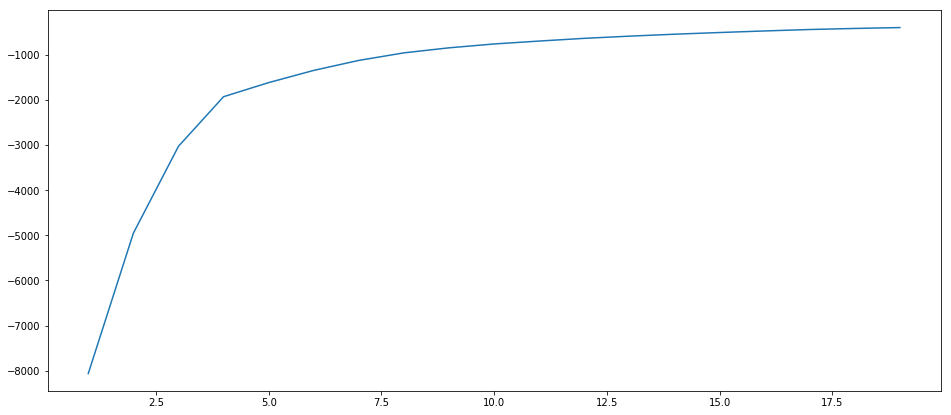

In [25]:
plot_scores(n_cluster, scores)

In [26]:
def set_k_means_features(df, kmeans):
    df['cluster'] = kmeans[14].predict(data1)
    df['feature1'] = data1[0]
    df['feature2'] = data1[1]
    
    return df

df1 = set_k_means_features(df1, kmeans)
df2 = set_k_means_features(df2, kmeans)

In [27]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

distance = getDistanceByPoint(data1, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

df1['anomaly_k_means'] = (distance >= threshold).astype(int)
df2['anomaly_k_means'] = (distance >= threshold).astype(int)

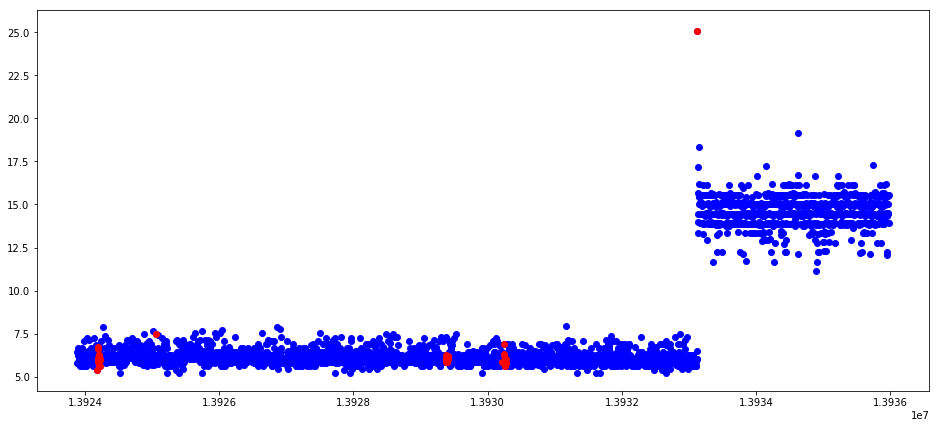

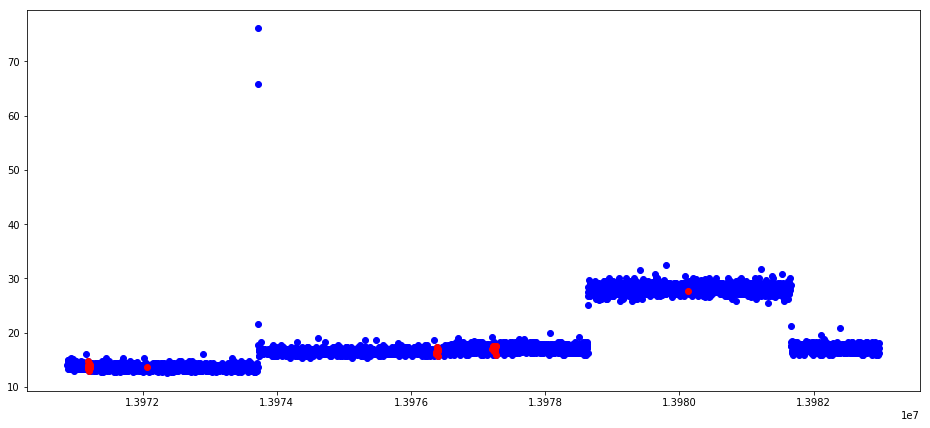

In [28]:
def plot_anomaly_k_means(df):
    fig, ax = plt.subplots()

    a = df.loc[df['anomaly_k_means'] == 1, ['time_epoch', 'value']]

    ax.scatter(df['time_epoch'], df['value'], color='blue')
    ax.scatter(a['time_epoch'],a['value'], color='red')
    plt.show()
    
plot_anomaly_k_means(df1)
plot_anomaly_k_means(df2)

In [29]:
def plot_hist_k_means(df):
    a = df.loc[df['anomaly_k_means'] == 0, 'value']
    b = df.loc[df['anomaly_k_means'] == 1, 'value']

    fig, axs = plt.subplots()
    axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
    plt.legend()
    plt.show()

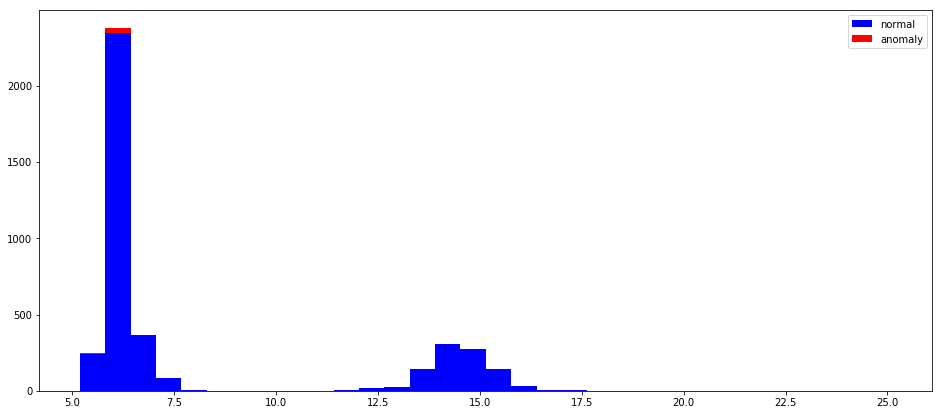

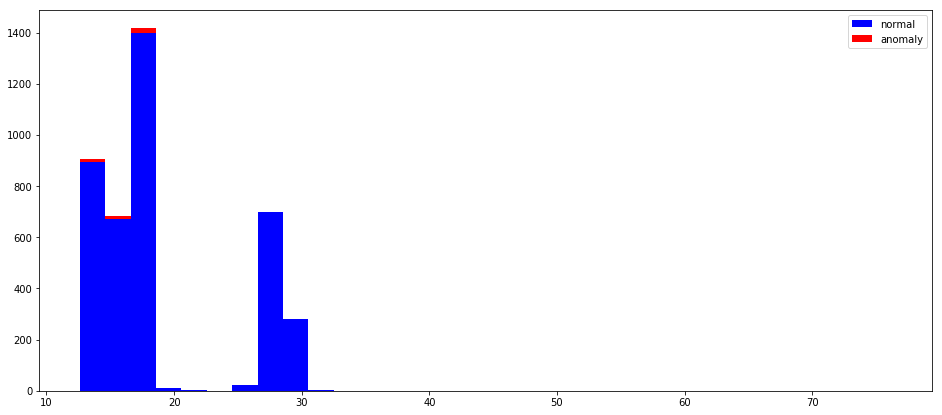

In [30]:
plot_hist_k_means(df1)
plot_hist_k_means(df2)

### Isolation Forest

In [31]:
outliers_fraction = 0.01

def prepare_data_for_i_f (df):
    data = df[['value', 'hours', 'week_day']]
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    return pd.DataFrame(np_scaled)
    
data1 = prepare_data_for_i_f(df1)
data2 = prepare_data_for_i_f(df2)

model = IsolationForest(contamination = outliers_fraction)

model.fit(data1)
    
def add_i_f_anomaly(df, model, data):
    df['anomaly_i_f'] = pd.Series(model.predict(data))
    df['anomaly_i_f'] = df['anomaly_i_f'].map( {1: 0, -1: 1} )
    return df

df1 = add_i_f_anomaly(df1, model, data1)
df2 = add_i_f_anomaly(df2, model, data2)

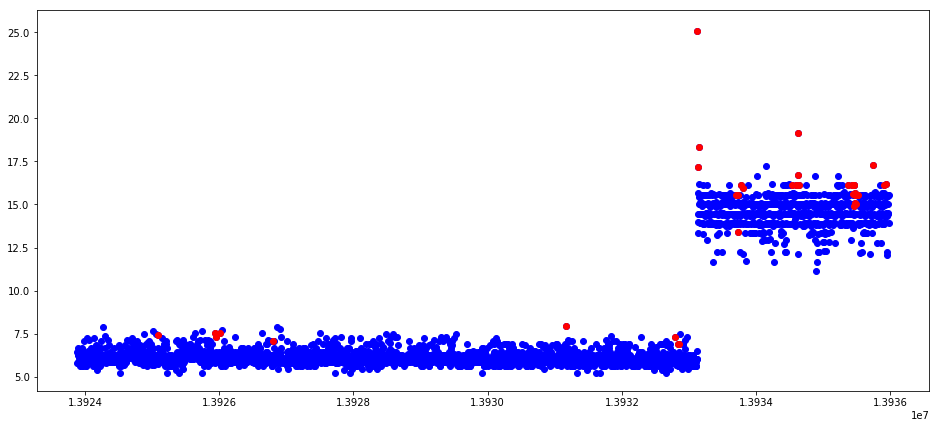

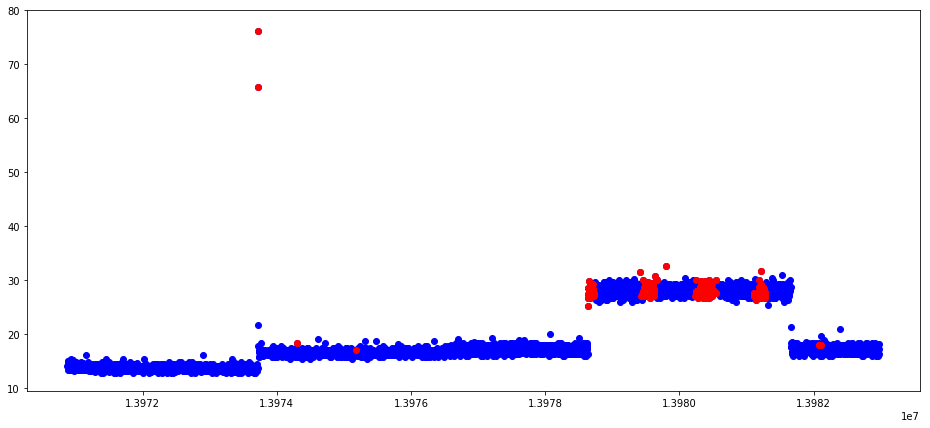

In [32]:
def plot_anomaly_i_f (df):
    fig, ax = plt.subplots()

    a = df.loc[df['anomaly_i_f'] == 1, ['time_epoch', 'value']]

    ax.scatter(df['time_epoch'], df['value'], color='blue')
    ax.scatter(a['time_epoch'],a['value'], color='red')
    plt.show()
    
plot_anomaly_i_f(df1)
plot_anomaly_i_f(df2)

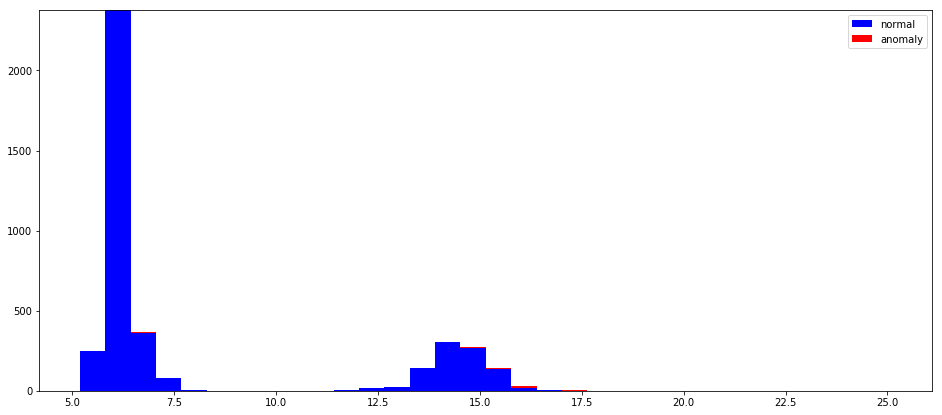

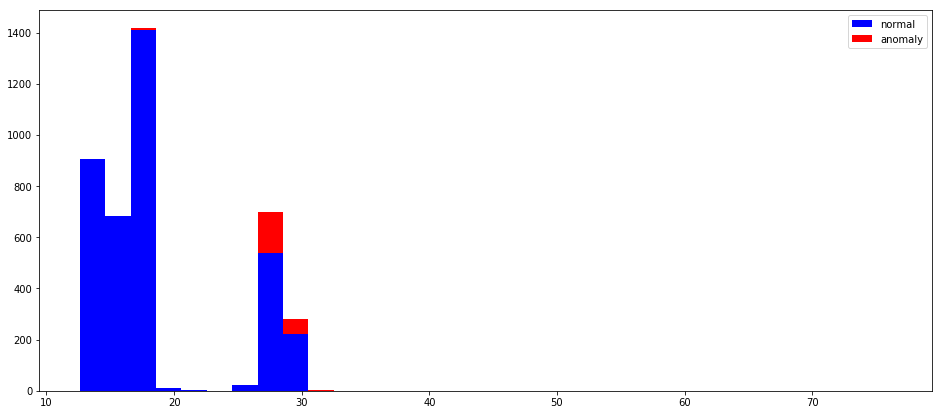

In [33]:
def plot_hist_i_f(df):
    a = df.loc[df['anomaly_i_f'] == 0, 'value']
    b = df.loc[df['anomaly_i_f'] == 1, 'value']

    fig, axs = plt.subplots()
    axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
    plt.legend()
    plt.show()
    
plot_hist_i_f(df1)
plot_hist_i_f(df2)

### OCSVM

In [34]:
outliers_fraction = 0.01

def prepare_data_for_ocsvm (df):
    data = df1[['value', 'hours', 'week_day']]
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    return pd.DataFrame(np_scaled)

data1 = prepare_data_for_ocsvm(df1)
data2 = prepare_data_for_ocsvm(df2)

model =  OneClassSVM(nu=0.95 * outliers_fraction + 0.05) 

model.fit(data1)

def add_ocsvm_anomaly(df, model, data):
    df['anomaly_ocsvm'] = pd.Series(model.predict(data))
    df['anomaly_ocsvm'] = df['anomaly_ocsvm'].map( {1: 0, -1: 1} )
    return df

df1 = add_ocsvm_anomaly(df1, model, data1)
df2 = add_ocsvm_anomaly(df2, model, data1)

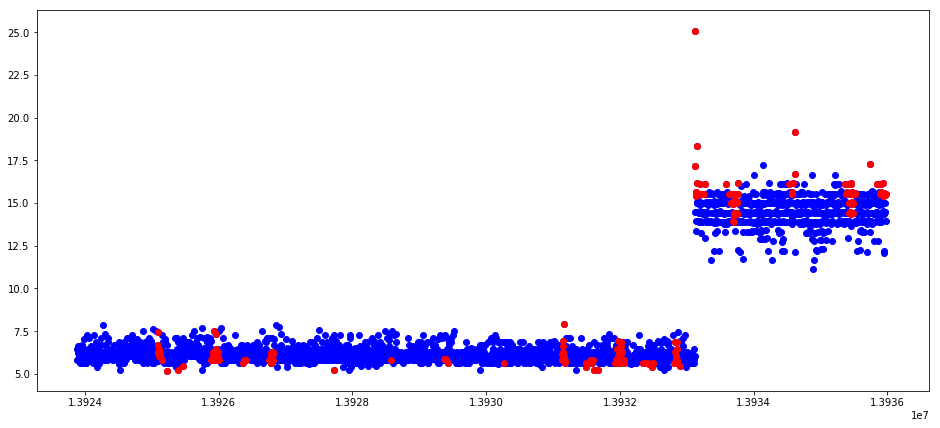

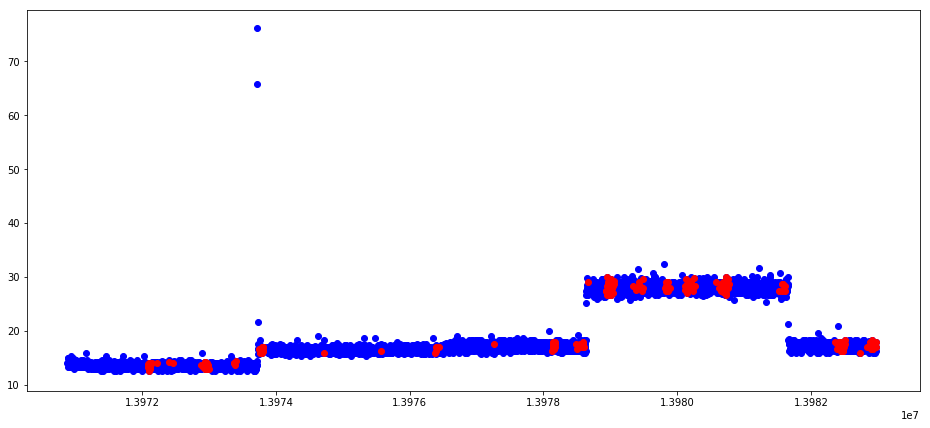

In [35]:
def plot_anomaly_ocsvm (df):
    fig, ax = plt.subplots()

    a = df.loc[df['anomaly_ocsvm'] == 1, ['time_epoch', 'value']]

    ax.scatter(df['time_epoch'], df['value'], color='blue')
    ax.scatter(a['time_epoch'],a['value'], color='red')
    plt.show()
    
plot_anomaly_ocsvm(df1)
plot_anomaly_ocsvm(df2)

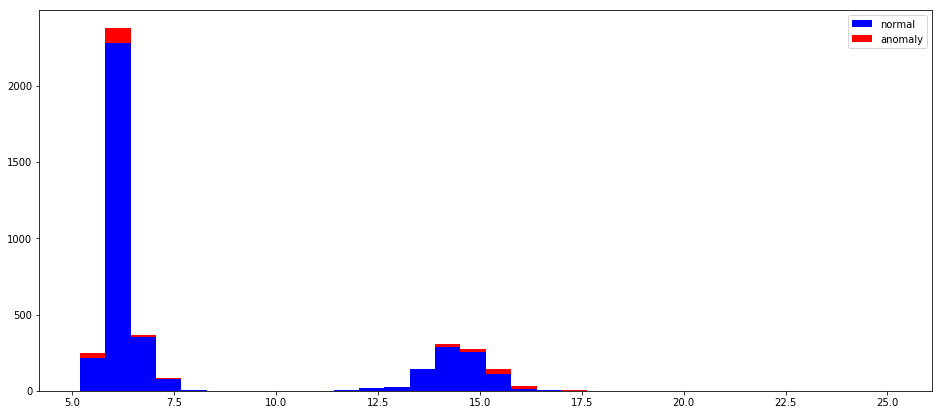

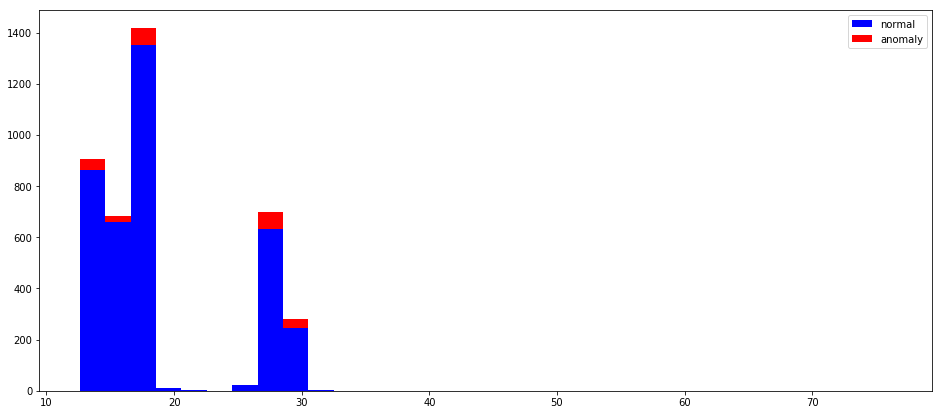

In [36]:
def plot_hist_ocsvm(df):
    a = df.loc[df['anomaly_ocsvm'] == 0, 'value']
    b = df.loc[df['anomaly_ocsvm'] == 1, 'value']

    fig, axs = plt.subplots()
    axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
    plt.legend()
    plt.show()
    
plot_hist_ocsvm(df1)
plot_hist_ocsvm(df2)

### RNN

In [37]:
def prepare_data_for_rnn (df):
    data = df1[['value', 'hours', 'week_day']]
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    return pd.DataFrame(np_scaled).values.astype(np.float32)

data1 = prepare_data_for_rnn(df1)
data2 = prepare_data_for_rnn(df2)

In [38]:
rows = len(data1)
split_factor = 0.2

test = data1[0:int(rows*split_factor)]
train = data1[int(rows*split_factor):]

In [39]:
batch_size = 256
train_data = mx.gluon.data.DataLoader(train, batch_size, last_batch='keep', shuffle=False)
test_data = mx.gluon.data.DataLoader(test, batch_size, last_batch='keep', shuffle=False)

In [40]:
ctx = mx.cpu()

In [41]:
features = data1.shape[1]

model = gluon.nn.Sequential()
with model.name_scope():
    model.add(gluon.nn.Dense(16, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))

    model.add(gluon.nn.Dense(8, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))
    
    model.add(gluon.nn.Dense(16, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))
    
    model.add(gluon.nn.Dense(features))

model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

L = gluon.loss.L2Loss()

In [42]:
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = data
        output = model(data)
        loss = L(output, label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return loss_avg

In [43]:
epochs = 50

all_train_mse = []
all_test_mse = []

for e in range(epochs):
    for i, data in enumerate(train_data):
        
        data = data.as_in_context(ctx)
        label = data
        with autograd.record():
            output = model(data)
            loss = L(output, label)
            loss.backward()
        trainer.step(data.shape[0])
    
    train_mse = evaluate_accuracy(train_data, model, L)
    test_mse = evaluate_accuracy(test_data, model, L)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)

In [44]:
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

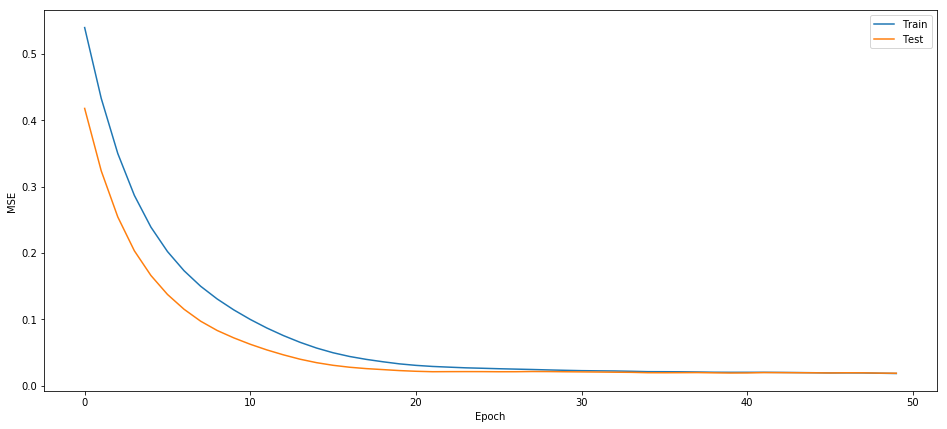

In [45]:
plot_errors(all_train_mse, all_test_mse)

In [46]:
def predict(to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(ctx)
        out = model(input)
        prediction = L(out, input).asnumpy().flatten()
        predictions = np.append(predictions, prediction)
    return predictions

In [47]:
def add_rnn_anomaly(df, predict, threshold, L, data):
    predictions = predict(data, L)
    
    df['anomaly_rnn'] = pd.Series(predictions)
    df['anomaly_rnn'] = df['anomaly_rnn'].apply(lambda v: int(v > threshold))
    return df

train_predictions = predict(train_data, L)
threshold =  np.mean(train_predictions) + 3 * np.std(train_predictions)

plot_data1 = mx.gluon.data.DataLoader(data1, batch_size, shuffle=False)
df1 = add_rnn_anomaly(df1, predict, threshold, L, plot_data1)

plot_data2 = mx.gluon.data.DataLoader(data2, batch_size, shuffle=False)
df2 = add_rnn_anomaly(df2, predict, threshold, L, plot_data2)

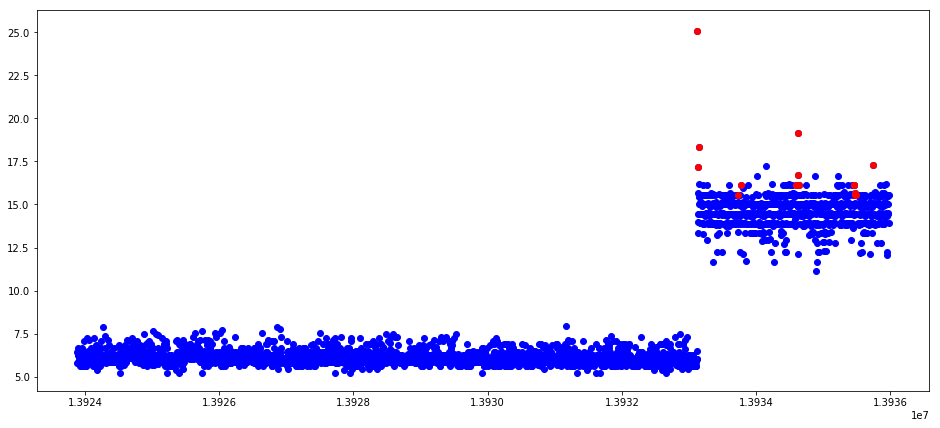

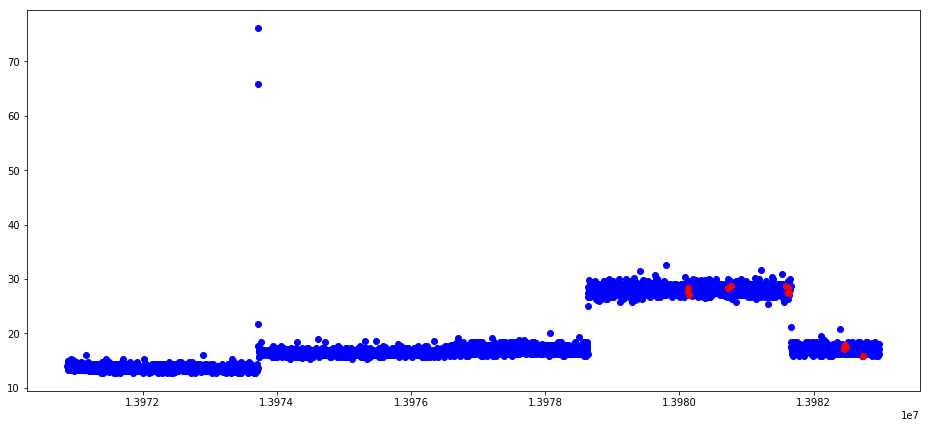

In [48]:
def plot_anomaly_rnn (df):
    fig, ax = plt.subplots()

    a = df.loc[df['anomaly_rnn'] == 1, ['time_epoch', 'value']]

    ax.scatter(df['time_epoch'], df['value'], color='blue')
    ax.scatter(a['time_epoch'],a['value'], color='red')
    plt.show()
    
plot_anomaly_rnn(df1)
plot_anomaly_rnn(df2)

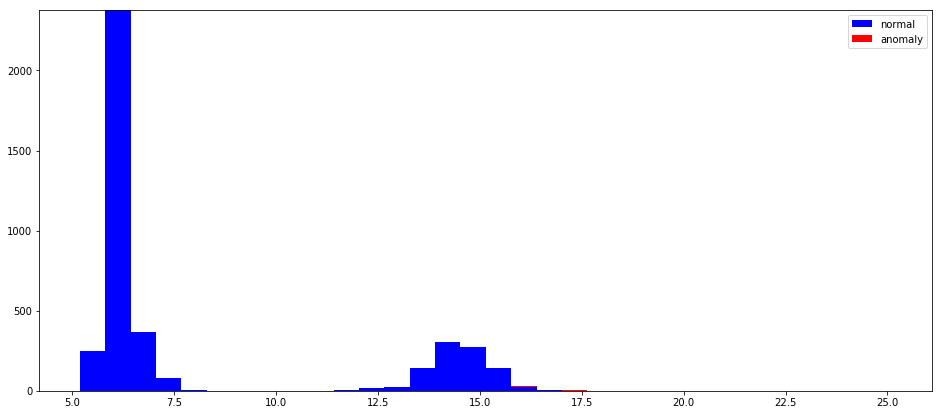

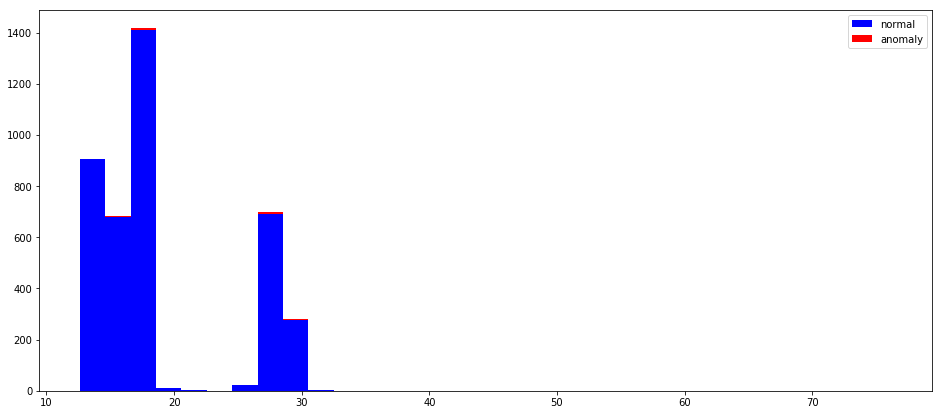

In [49]:
def plot_hist_rnn(df):
    a = df.loc[df['anomaly_rnn'] == 0, 'value']
    b = df.loc[df['anomaly_rnn'] == 1, 'value']

    fig, axs = plt.subplots()
    axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
    plt.legend()
    plt.show()
    
plot_hist_rnn(df1)
plot_hist_rnn(df2)

### LSTM

In [50]:
batch_size = 128

def prepare_data_for_lstm (df):
    data = df[['value', 'hours', 'week_day']]
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    return pd.DataFrame(np_scaled).values.astype(np.float32)

data1 = prepare_data_for_lstm(df1)
data2 = prepare_data_for_lstm(df2)

In [51]:
rows = len(data1)
split_factor = 0.2

test = data1[0:int(rows*split_factor)]
train = data1[int(rows*split_factor):]

In [52]:
train_data = mx.gluon.data.DataLoader(train, batch_size, last_batch='keep', shuffle=False)
test_data = mx.gluon.data.DataLoader(test, batch_size, last_batch='keep', shuffle=False)

In [53]:
ctx = mx.cpu()

In [54]:
features = data1.shape[1]

model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(features, dropout=0.35))
    model.add(mx.gluon.rnn.LSTM(features))

model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.01})

L = gluon.loss.L2Loss()

In [55]:
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 1, features))
        label = data
        output = model(data)
        loss = L(output, label)
        loss_avg = loss_avg * i / (i + 1) + nd.mean(loss).asscalar() / (i + 1)
    return loss_avg

In [56]:
epochs = 40

all_train_mse = []
all_test_mse = []

for e in range(epochs):
    for i, data in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1, 1, features))
        label = data
        with autograd.record():
            output = model(data)
            loss = L(output, label)
        loss.backward()
        trainer.step(batch_size)
    
    train_mse = evaluate_accuracy(train_data, model, L)
    test_mse = evaluate_accuracy(test_data, model, L)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)

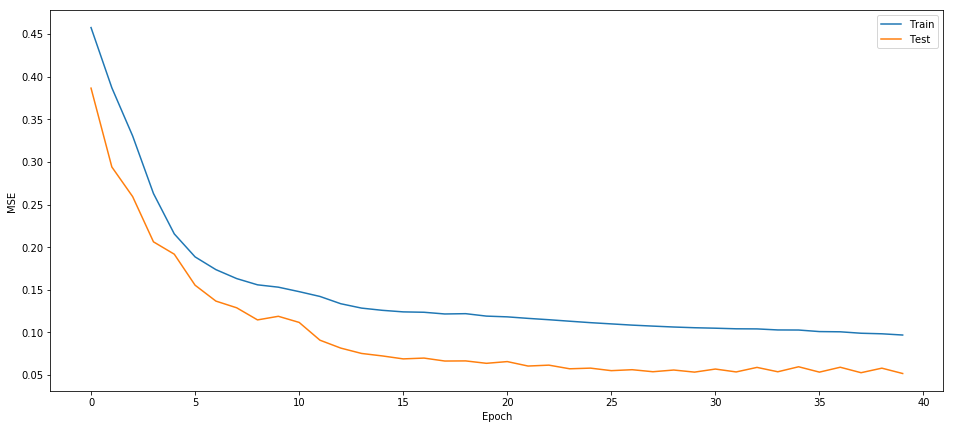

In [57]:
plot_errors(all_train_mse, all_test_mse)

In [58]:
def predict(to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(ctx).reshape((-1,1,features))
        out = model(input)
        prediction = L(out, input).asnumpy().flatten()
        predictions = np.append(predictions, prediction)
    return predictions

In [59]:
def add_lstm_anomaly(df, predict, threshold, L, data):
    predictions = predict(data, L)
    df['anomaly_lstm'] = pd.Series(predictions)
    df['anomaly_lstm'] = df['anomaly_lstm'].apply(lambda v: int(v > threshold))
    return df

train_predictions = predict(train_data, L)
threshold =  np.mean(train_predictions) + 3 * np.std(train_predictions)

plot_data1 = mx.gluon.data.DataLoader(data1, batch_size, shuffle=False)
df1 = add_lstm_anomaly(df1, predict, threshold, L, plot_data1)

plot_data2 = mx.gluon.data.DataLoader(data2, batch_size, shuffle=False)
df2 = add_lstm_anomaly(df2, predict, threshold, L, plot_data2)

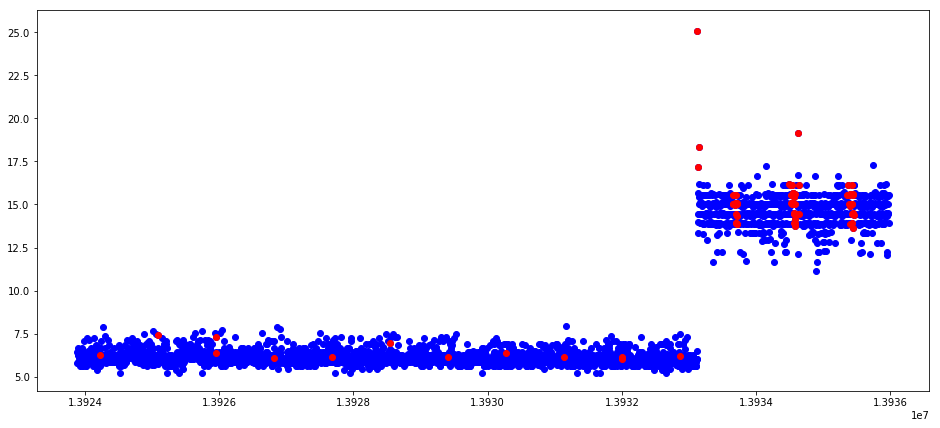

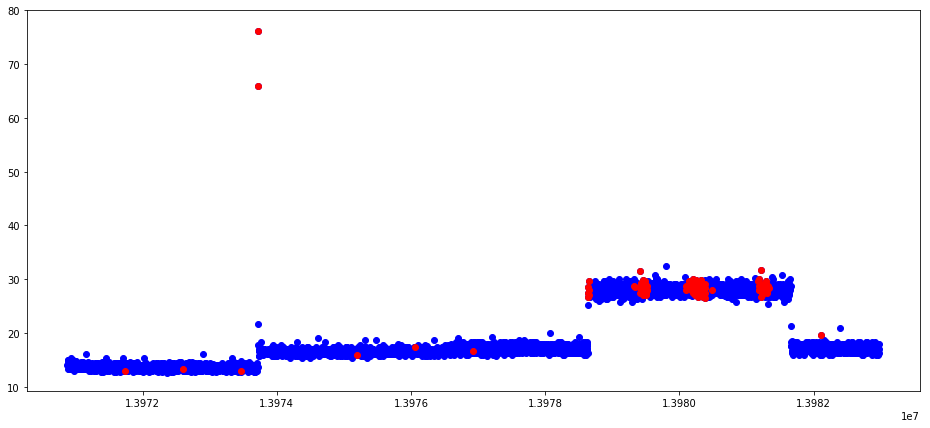

In [60]:
def plot_anomaly_lstm (df):
    fig, ax = plt.subplots()

    a = df.loc[df['anomaly_lstm'] == 1, ['time_epoch', 'value']]

    ax.scatter(df['time_epoch'], df['value'], color='blue')
    ax.scatter(a['time_epoch'],a['value'], color='red')
    plt.show()
    
plot_anomaly_lstm(df1)
plot_anomaly_lstm(df2)

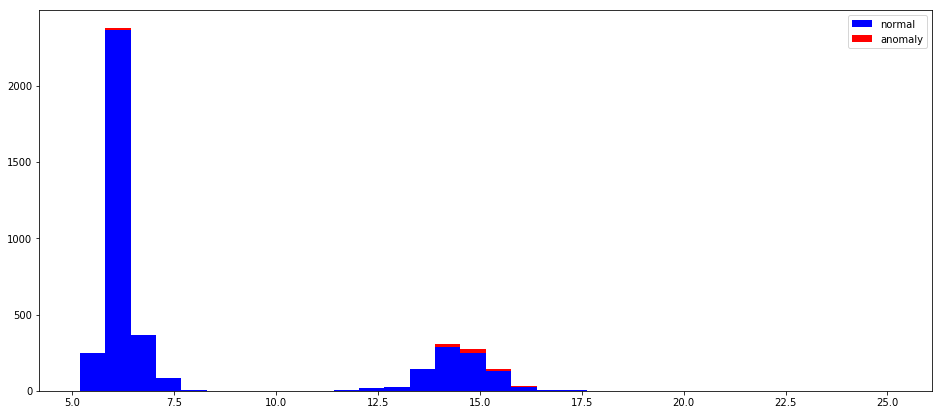

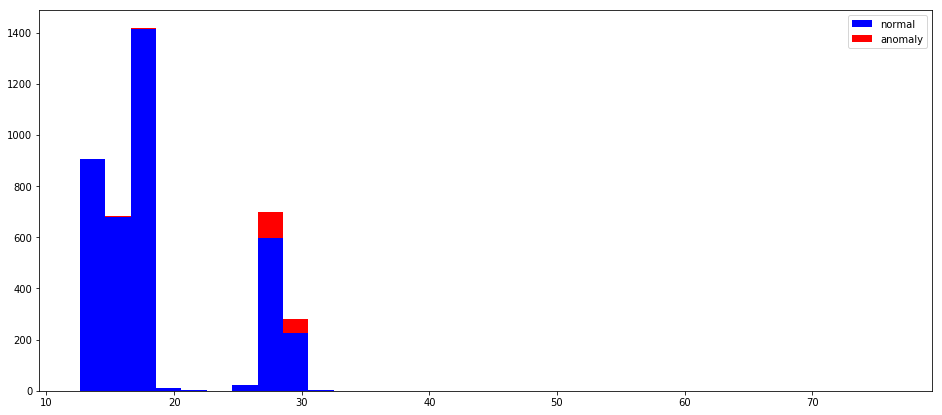

In [61]:
def plot_hist_lstm(df):
    a = df.loc[df['anomaly_lstm'] == 0, 'value']
    b = df.loc[df['anomaly_lstm'] == 1, 'value']

    fig, axs = plt.subplots()
    axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
    plt.legend()
    plt.show()
    
plot_hist_lstm(df1)
plot_hist_lstm(df2)